In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


df = pd.read_csv('food_nutrition.csv')


In [311]:
df.columns


Index(['NDB_No', 'Long_Desc', 'Msre_Desc', 'Gm_Wgt', 'Water_g', 'Energ_Kcal',
       'Protein_g', 'Lipid_Tot_g', 'Ash_g', 'Carbohydrt_g', 'Fiber_TD_g',
       'Sugar_Tot_g', 'Calcium_mg', 'Iron_mg', 'Magnesium_mg', 'Phosphorus_mg',
       'Potassium_mg', 'Sodium_mg', 'Zinc_mg', 'Copper_mg', 'Manganese_mg',
       'Selenium_µg', 'Vit_C_mg', 'Thiamin_mg', 'Riboflavin_mg', 'Niacin_mg',
       'Panto_Acid_mg', 'Vit_B6_mg', 'Folate_Tot_µg', 'Food_Folate_µg',
       'Folate_DFE_µg', 'Choline_Tot_mg', 'Vit_B12_µg', 'Vit_A_RAE',
       'Retinol_µg', 'Alpha_Carot_µg', 'Beta_Carot_µg', 'Beta_Crypt_µg',
       'Lycopene_µg', 'LutZea_ug', 'Vit_E_mg', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_µg', 'FA_Poly_g', 'Cholestrl_mg', 'GmWt_1', 'GmWt_Desc1',
       'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct'],
      dtype='object')

## Creating a Health score

In [312]:
# nutrients tiers defined
macro_nutrients = ['Protein_g', 'Carbohydrt_g', 'Lipid_Tot_g', 'Sugar_Tot_g','Fiber_TD_g', 'Sodium_mg', 'Potassium_mg']

minerals = [
    'Calcium_mg', 'Iron_mg', 'Magnesium_mg',
    'Phosphorus_mg', 'Zinc_mg', 'Copper_mg',
    'Manganese_mg', 'Selenium_µg'
]

vitamins = [
    'Vit_C_mg', 'Thiamin_mg', 'Riboflavin_mg', 'Niacin_mg', 'Panto_Acid_mg',
    'Vit_B6_mg', 'Folate_Tot_µg', 'Food_Folate_µg', 'Folate_DFE_µg',
    'Choline_Tot_mg', 'Vit_B12_µg', 'Vit_A_RAE', 'Retinol_µg',
    'Alpha_Carot_µg', 'Beta_Carot_µg', 'Beta_Crypt_µg', 'Lycopene_µg',
    'LutZea_ug', 'Vit_E_mg', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_µg'
]

# non nutritional columns
non_nutrition = ['NDB_No', 'Long_Desc', 'Msre_Desc', 'Gm_Wgt', 'GmWt_1', 'GmWt_Desc1', 
                 'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct']


# set weights
weights = {
    'macro_nutrients':0.5,
    'minerals': 0.3,
    'vitamins': 0.2
}

In [313]:
# normalize nutrient columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
nutrients = macro_nutrients + minerals + vitamins

df_scaled = df.copy()

df_scaled[nutrients] = scaler.fit_transform(df_scaled[nutrients])

In [314]:
# subscores for each category
df_scaled['score_macro'] = df_scaled[macro_nutrients].mean(axis=1)
df_scaled['score_minerals'] = df_scaled[minerals].mean(axis=1)
df_scaled['score_vitamins'] = df_scaled[vitamins].mean(axis=1)

df_scaled['Health_Score'] = (
    df_scaled['score_macro'] * weights['macro_nutrients'] +
    df_scaled['score_minerals'] * weights['minerals'] +
    df_scaled['score_vitamins'] * weights['vitamins']
)

# scale health score to 0-100
df_scaled['Health_Score'] = 100 * (
    (df_scaled['Health_Score'] - df_scaled['Health_Score'].min()) /
    (df_scaled['Health_Score'].max() - df_scaled['Health_Score'].min())
)

#### Penalty system for excessive sugar, sodium or cholestrol

In [315]:
# Define penalty system (per 100g serving) ---
penalty_thresholds = {
    'Sugar_Tot_g': 15,        # >15g sugar → sugary food
    'Sodium_mg': 500,         # >500mg sodium → high salt
    'Cholestrl_mg': 100,      # >100mg cholesterol → high fat/meat
    'FA_Sat_g': 5             # >5g saturated fat → high saturated fat
}

penalty_weights = {
    'Sugar_Tot_g': 0.15,
    'Sodium_mg': 0.25,
    'Cholestrl_mg': 0.2,
    'FA_Sat_g': 0.2
}

# Apply penalties ---
df_penalty = df_scaled.copy()

for nutrient, threshold in penalty_thresholds.items():
    if nutrient in df_penalty.columns:
        excess = (df_penalty[nutrient] > threshold).astype(int)
        df_penalty[f"{nutrient}_penalty"] = excess * penalty_weights[nutrient] * 100

# Sum total penalty
penalty_cols = [c for c in df_penalty.columns if c.endswith('_penalty')]
df_penalty['Total_Penalty'] = df_penalty[penalty_cols].sum(axis=1)

#  Adjust health score (floor at 0, cap at 100) ---
df_penalty['New_Health_Score'] = (
    df_penalty['Health_Score'] - df_penalty['Total_Penalty']
).clip(lower=0, upper=100)

# Categorize before and after penalty ---
def categorize_health(score):
    if score >= 75:
        return "Excellent"
    elif score >= 50:
        return "Good"
    elif score >= 25:
        return "Fair"
    else:
        return "Poor"

df_penalty['Health_Category'] = df_penalty['Health_Score'].apply(categorize_health)
df_penalty['New_Category'] = df_penalty['New_Health_Score'].apply(categorize_health)



In [316]:
# Display final preview ---
df_penalty[['Long_Desc', 'Health_Score', 'New_Health_Score','Health_Category',
            'New_Category']].head(10)

,Long_Desc,Health_Score,New_Health_Score,Health_Category,New_Category
0,unknown,19.704467,0.000000,Poor,Poor
1,unknown,19.233351,0.000000,Poor,Poor
2,unknown,14.683385,0.000000,Poor,Poor
3,unknown,34.944399,34.944399,Fair,Fair
4,unknown,32.356278,32.356278,Fair,Fair
5,unknown,25.732186,25.732186,Fair,Fair
6,unknown,29.636217,29.636217,Fair,Fair
7,unknown,34.307743,34.307743,Fair,Fair
8,unknown,35.372116,35.372116,Fair,Fair
9,unknown,33.378986,13.378986,Fair,Poor


<Axes: >

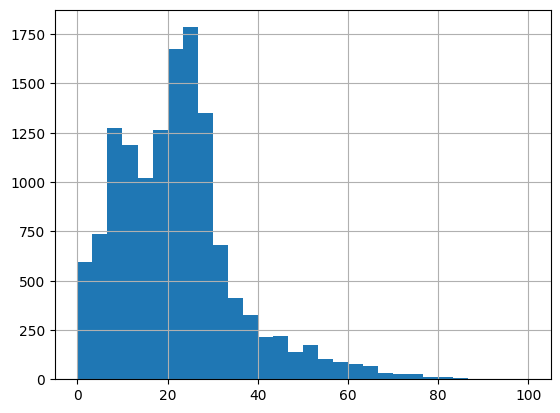

In [317]:
df_final = df_penalty.copy()

df_final['New_Health_Score'].hist(bins=30)

## Clustering

In [318]:
# Applying HDBSCAN clustering
import hdbscan
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42)

#X = df_final[nutrients].copy()

# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN( min_cluster_size=40, min_samples=5, metric='euclidean', cluster_selection_epsilon=0.05, prediction_data=True )


clusterer.fit(train_df[nutrients])
# fit and assing clusters
train_df['Cluster'] = clusterer.labels_

# 4️⃣ Inspect
print(train_df['Cluster'].value_counts().head())
print(f"Noise points (unclustered): {(train_df['Cluster'] == -1).sum()}")


Cluster
-1     7329
 5      261
 9      242
 33     237
 6      139
Name: count, dtype: int64
Noise points (unclustered): 7329


In [319]:
from hdbscan import prediction

# Assign clusters to test data using the trained HDBSCAN model
test_df['Cluster'], strengths = prediction.approximate_predict(clusterer, test_df[nutrients])

test_df=test_df[test_df['Cluster'] != -1]


# Optionally inspect
print(test_df['Cluster'].value_counts().head())
print(f"Noise points (unclustered): {(test_df['Cluster'] == -1).sum()}")


Cluster
5     71
33    67
9     62
6     44
7     43
Name: count, dtype: int64
Noise points (unclustered): 0


In [320]:
from difflib import get_close_matches

get_close_matches("Apple, raw", df_final['Long_Desc'], n=5, cutoff=0.3)


['Kale, raw', 'Nopales, raw', 'Eppaw, raw', 'Millet, raw', 'Celery, raw']

In [334]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_substitutes(food_name, df, nutrients, top_n=5):
    # Check if food exists
    if food_name not in df['Long_Desc'].values:
        return f"'{food_name}' not found in the dataset."
    
    # Extract the food entry
    food_row = df[df['Long_Desc'] == food_name].iloc[0]
    food_cluster = food_row['Cluster']

    # --- Handle noise points (cluster = -1) ---
    if food_cluster == -1:
        # Compute cosine similarity across nutrient features
        sims = cosine_similarity([food_row[nutrients]], df[nutrients])[0]
        df = df.copy()
        df['similarity'] = sims
        substitutes = (
            df[df['Long_Desc'] != food_name]
            .sort_values('similarity', ascending=False)
            .head(top_n)[['Long_Desc', 'Health_Score', 'similarity']]
        )
        return substitutes

    # --- For clustered foods ---
    cluster_foods = df[df['Cluster'] == food_cluster].copy()
    
    # Exclude the food itself and any unknowns
    cluster_foods = cluster_foods[cluster_foods['Long_Desc'].str.lower() != "unknown"]
    cluster_foods = cluster_foods[cluster_foods['Long_Desc'] != food_name]

    # Compute health score similarity
    cluster_foods['similarity'] = 1 - abs(
        cluster_foods['Health_Score'] - food_row['Health_Score']
    ) / 100

    # Return top substitutes
    return cluster_foods.sort_values('similarity', ascending=False).head(top_n)[
        ['Long_Desc', 'Health_Score', 'similarity']
    ]


In [335]:
recommend_substitutes("Celery, raw", train_df, nutrients)

,Long_Desc,Health_Score,similarity
3314,"Celery, cooked, boiled, drained, without salt",8.127638,0.989710
3315,"Celery, cooked, boiled, drained, without salt",8.127638,0.989710
3475,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.969207
3480,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.969207
3479,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.969207


### Using the Health-Weighted Cosine Similarity
- final_score= α × health_score_sim + (1−α) × nutrient_cosine_sim

- α(alpha controls how much weight you give to health vs nutrient similarity)

In [ ]:
def recommend_substitutes_health_weighted(
    food_name, df, nutrients, alpha=0.6, health_weight=0.3, top_n=5, verbose=False, exclude_list=None
):
    df = df.copy()

    # --- prep nutrients ---
    nutrients = [c for c in nutrients if c in df.columns]
    df[nutrients] = df[nutrients].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=nutrients)

    # --- exclusions ---
    if exclude_list is None:
        exclude_list = ["unknown", "sugars, brown"]

    df = df[~df['Long_Desc'].str.lower().isin([x.lower() for x in exclude_list])].reset_index(drop=True)

    # --- fuzzy matching ---
    if food_name not in df['Long_Desc'].values:
        match = get_close_matches(food_name, df['Long_Desc'], n=1, cutoff=0.3)
        if not match:
            return f"No close match found for '{food_name}'"
        food_name = match[0]
        if verbose:
            print(f"Using closest match: {food_name}")

    # --- skip if excluded ---
    if food_name.lower() in [x.lower() for x in exclude_list]:
        return f"'{food_name}' is excluded from recommendations."

    # --- locate food ---
    food_row = df.loc[df['Long_Desc'] == food_name].iloc[0]
    food_cluster = food_row['Cluster']

    # --- cluster or fallback ---
    if food_cluster == -1:
        if verbose:
            print(f"⚠️ '{food_name}' is a noise point — using full dataset.")
        cluster_foods = df[df['Long_Desc'] != food_name].copy()
    else:
        cluster_foods = df[df['Cluster'] == food_cluster].copy()
        cluster_foods = cluster_foods[cluster_foods['Long_Desc'] != food_name]

        if cluster_foods.empty:
            if verbose:
                print(f"No others in cluster {food_cluster}, switching to full dataset.")
            cluster_foods = df[df['Long_Desc'] != food_name].copy()

    # --- reapply exclusions ---
    cluster_foods = cluster_foods[~cluster_foods['Long_Desc'].str.lower().isin([x.lower() for x in exclude_list])]

    # --- similarity calculations ---
    food_vec = food_row[nutrients].values.reshape(1, -1)
    cluster_matrix = cluster_foods[nutrients].values
    cos_sim = cosine_similarity(food_vec, cluster_matrix).flatten()

    food_health = food_row['Health_Score']
    health_sim = 1 - abs(cluster_foods['Health_Score'] - food_health) / 100

    # --- align safely ---
    min_len = min(len(cos_sim), len(health_sim))
    cluster_foods = cluster_foods.iloc[:min_len]
    cos_sim = cos_sim[:min_len]
    health_sim = health_sim.iloc[:min_len]

    # --- combine similarities ---
    cluster_foods['base_score'] = alpha * cos_sim + (1 - alpha) * health_sim

    # --- apply health weighting ---
    max_health = cluster_foods['Health_Score'].max()
    cluster_foods['health_weight_factor'] = cluster_foods['Health_Score'] / max_health
    cluster_foods['final_score'] = (
        (1 - health_weight) * cluster_foods['base_score']
        + health_weight * cluster_foods['health_weight_factor']
    )

    # --- final sort & return ---
    return (
        cluster_foods.sort_values('final_score', ascending=False)
        .head(top_n)[['Long_Desc', 'Health_Score', 'base_score', 'final_score']]
        .reset_index(drop=True)
    )


In [355]:
recommend_substitutes_health_weighted("Celery, raw", train_df, nutrients, alpha=0.7, health_weight=0.3)


,Long_Desc,Health_Score,base_score,final_score
0,"Celery, cooked, boiled, drained, without salt",8.127638,0.989755,0.717212
1,"Celery, cooked, boiled, drained, without salt",8.127638,0.989755,0.717212
2,"Celery flakes, dried",81.289551,0.657389,0.704041
3,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.972627,0.696363
4,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.972627,0.696363


### Constraint Filtering

In [356]:
import re
def recommend_substitutes_with_constraints(
    food_name, df, nutrients, alpha=0.6, health_weight=0.3, top_n=5, calorie_range=None, exclude_ingredients=None, include_only=None
):
    """
    Recommend substitutes considering:
    - Nutrient + health similarity (from recommend_substitutes_health_weighted)
    - User dietary constraints (calorie range, allergies, diet type, etc.)
    
    Parameters:
      calorie_range: tuple(min_cal, max_cal) -> filter by calories if provided
      exclude_ingredients: list -> foods containing these terms are excluded
      include_only: list -> foods must contain at least one of these terms
    """
    # Step 1 — Get weighted similarity recommendations
    results = recommend_substitutes_health_weighted(
        food_name, df, nutrients, alpha, health_weight, top_n=len(df)
    )

    if isinstance(results, str):
        return results  # In case of "no match" message

    # Step 2 — Merge energy info using your column name
    energy_col = "Energ_Kcal"
    results = results.merge(df[['Long_Desc', energy_col]], on='Long_Desc', how='left')

    # Step 3 — Apply constraint filters
    if calorie_range:
        min_cal, max_cal = calorie_range
        results = results[
            (results[energy_col] >= min_cal) & (results[energy_col] <= max_cal)
        ]

    if exclude_ingredients:
        # Place (?i) only once for case-insensitive matching
        pattern = "(?i)" + "|".join([re.escape(term) for term in exclude_ingredients])
        results = results[~results['Long_Desc'].str.contains(pattern, na=False)]

    if include_only:
        pattern = "(?i)" + "|".join([re.escape(term) for term in include_only])
        results = results[results['Long_Desc'].str.contains(pattern, na=False)]

    # Step 4 — Return top N ranked
    return (
        results.sort_values('final_score', ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )


In [357]:
recommend_substitutes_with_constraints(
    "Celery, raw", train_df, nutrients=nutrients, calorie_range=(10, 100), exclude_ingredients=["cheese", "syrup"], include_only=["raw", "fresh"], top_n=5
)


,Long_Desc,Health_Score,base_score,final_score,Energ_Kcal
0,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.973768,0.697161,14
1,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.973768,0.697161,14
2,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.973768,0.697161,14
3,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.973768,0.697161,14
4,"Lettuce, iceberg (includes crisphead types), raw",5.174679,0.973768,0.697161,14


### Evaluation

In [358]:
# 1. cluster precision
def evaluate_cluster_precision(df, nutrients, top_n=5):
    correct, total = 0, 0
    for food in df['Long_Desc'].sample(50, random_state=42):  # test on sample
        try:
            recs = recommend_substitutes_health_weighted(food, df, nutrients, top_n=top_n)
            if isinstance(recs, str):  # skip errors
                continue
            cluster_true = df.loc[df['Long_Desc'] == food, 'Cluster'].values[0]
            cluster_pred = df.loc[df['Long_Desc'].isin(recs['Long_Desc']), 'Cluster']
            correct += (cluster_pred == cluster_true).sum()
            total += len(cluster_pred)
        except:
            pass
    return correct / total if total > 0 else 0


In [359]:
#2. health score consistency
def evaluate_health_consistency(df, nutrients, top_n=5):
    diffs = []
    for food in df['Long_Desc'].sample(50, random_state=42):
        try:
            recs = recommend_substitutes_health_weighted(food, df, nutrients, top_n=top_n)
            if isinstance(recs, str):
                continue
            food_health = df.loc[df['Long_Desc'] == food, 'Health_Score'].values[0]
            avg_rec_health = recs['Health_Score'].mean()
            diffs.append(avg_rec_health - food_health)
        except:
            pass
    return np.mean(diffs)


In [360]:
#3. nutrient cosine similarity
def evaluate_similarity(df, nutrients, top_n=5):
    sims = []
    for food in df['Long_Desc'].sample(50, random_state=42):
        try:
            recs = recommend_substitutes_health_weighted(food, df, nutrients, top_n=top_n)
            if isinstance(recs, str):
                continue
            food_vec = df.loc[df['Long_Desc'] == food, nutrients].values
            rec_vecs = df.loc[df['Long_Desc'].isin(recs['Long_Desc']), nutrients].values
            sim = cosine_similarity(food_vec, rec_vecs).mean()
            sims.append(sim)
        except:
            pass
    return np.mean(sims)


In [361]:
cluster_acc = evaluate_cluster_precision(test_df, nutrients)
health_gain = evaluate_health_consistency(test_df, nutrients)
nutrient_sim = evaluate_similarity(test_df, nutrients)

print(f"Cluster Precision: {cluster_acc:.2f}")
print(f"Avg Health Gain: {health_gain:.2f}")
print(f"Avg Nutrient Similarity: {nutrient_sim:.2f}")


Cluster Precision: 0.86
Avg Health Gain: 0.97
Avg Nutrient Similarity: 0.88


- **Cluster Precision=0.86**: 86% of the recommendations stay within the correct nutrient groups
- **Avg Health Gain=0.97**: most substitutes have similar or slightly healthy scores
- **Avg Nutrients similarity=0.88**: strong nutrients overlap between the food and its substitutes